# Week 2: Keyword search using dynamic time warping
This week we're going to apply KWS to some actual speech data. Even though last week we learned about WFSTs and how they can be applied to KWS, we're not going to talk about WFSTs or Markov models this week. Instead, we're going to introduce *Dynamic Time Warping* (DTW), a method for comparing to sequences of data that can be used for speech-to-speech KWS.

"Speech-to-speech" means that instead of looking for a keyword by its *string*, we take the *audio* of an example keyword and compare the keyword audio to a sentence to determine if that sentence contains it. Since we're making comparisons between two different audio sequences, we need a metric that will describe the similarity of two sequences. That's where DTW comes into play.

Before starting this week's coding exercise, I recommend watching [all four videos from Herman Kamper on DTW](https://www.youtube.com/playlist?list=PLmZlBIcArwhMJoGk5zpiRlkaHUqy5dLzL). Once you're done with that, we can dive into applying DTW to some audio!

In [720]:
import os
from glob import glob
import pandas as pd
import librosa
from librikws import *
import numpy as np
from tslearn.metrics import dtw_path, dtw
from scipy.spatial.distance import cdist, cosine
from praatio import textgrid
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

## Section 1: Comparing sequences with Dynamic Time Warping

Hopefully by now you've watched the youtube videos, and you're familiar with DTW. Still, it's useful to have a demo to play with in Python. To do that, let's two simple sequences of 5 points, where the first sequence has a spike at the fourth point and the second sequence has a spike at the second point.

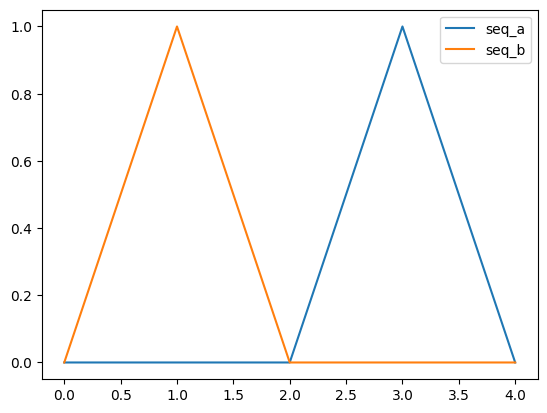

In [721]:
fig, ax = plt.subplots()
seq_a = np.array([0,0,0,1,0])
seq_b = np.array([0,1,0,0,0])
ax.plot(seq_a, label='seq_a')
ax.plot(seq_b, label='seq_b')
ax.legend()
plt.show()

I've included a simple implementation of the DTW algorithm so we can visualize what the matrix looks like for this sequence.

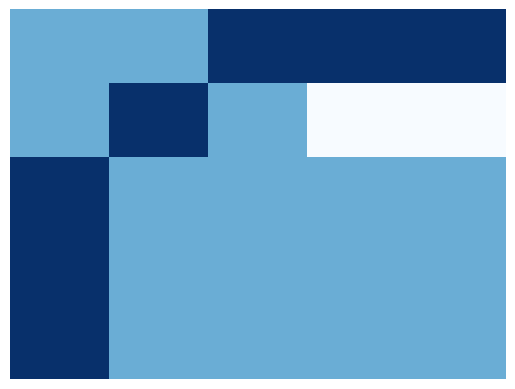

In [722]:
def get_dtw_matrix(seq_a, seq_b, distance_funct = 'absolute_diff'):
    if distance_funct == 'absolute_diff':
        distance_funct = lambda a, b: np.abs(a-b)

    # pad DTW matrix with an empty row
    padded_len = seq_a.shape[0]+1
    padded_width = seq_b.shape[0]+1
    dtw_matrix = np.full((padded_len,padded_width), np.inf)
    dtw_matrix[0,0]=0

    for i, a_i in enumerate(seq_a, start=1):
        for j, b_j in enumerate(seq_b, start=1):
            current_distance = distance_funct(a_i, b_j)
            
            left = dtw_matrix[i,j-1]
            bottom = dtw_matrix[i-1,j]
            diag = dtw_matrix[i-1,j-1]

            prev_distance = min(left, bottom, diag)

            dtw_matrix[i,j] = current_distance + prev_distance
    # trim padded
    return dtw_matrix[1:,1:]

def plot_distance_matrix(distance_matrix, ax):
    ax.imshow(1-distance_matrix, origin='lower', cmap='Blues', aspect='auto')
    ax.axis("off")
    # ax.autoscale(False)

distance_matrix = get_dtw_matrix(seq_a, seq_b)
fig, ax = plt.subplots()
plot_distance_matrix(distance_matrix, ax)
plt.show()

Let's plot the sequences alongside the matrix for best visibility and visualize the path through the DTW marix (code adapted from [tslearn documentation](https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html#sphx-glr-auto-examples-metrics-plot-dtw-py)).

In [723]:
def get_dtw_axes() -> Tuple[plt.Axes, plt.Axes, plt.Axes]:
    """
    Returns:
                Tuple[left_ax, center_ax, top_ax], pyplot axes
                corresponding to top, center and left rectangles
                where seq_a is visualized in top, seq_b in left
                and the distance matrix and path in center.
    """
    fig = plt.figure(figsize=(5, 5))
    
    # definitions for the axes
    left, bottom = 0.01, 0.1
    left_width = top_height = 0.2
    inner_left = left + left_width + 0.02
    width = height = 0.65
    bottom_of_top = bottom + height + 0.02
    
    # (left, bottom, width, height)
    left_rectangle = [left, bottom, left_width, height]
    center_rectangle = [inner_left, bottom, width, height]
    top_rectangle = [inner_left, bottom_of_top, width, top_height]
    
    top_ax = plt.axes(top_rectangle)
    center_ax = plt.axes(center_rectangle)
    left_ax = plt.axes(left_rectangle)

    return left_ax, center_ax, top_ax

def plot_dtw_kws(seq_a, seq_b, distance_matrix=None, path=None):
    """
    Arguments:
        seq_a:              First sequence of numbers of vectors to compare
        seq_b:              Second sequence of numbers of vectors to compare
        distance_matrix:    Optional: pre-computed distance matrix (default
                            behavior is to call `get_dtw_matrix(seq_a, seq_b)`)
        path:               Optional: pre-computed path (default behavior is to
                            call `tslearn.dtw_path(seq_a, seq_b)`)
    
    Plots two sequences along with similarity matrix and path.
    """
    if distance_matrix is None:
        distance_matrix = get_dtw_matrix(seq_a, seq_b)
    if path is None:
        path, _ = dtw_path(seq_a, seq_b)
    
    top, center, left = get_dtw_axes()
    plot_distance_matrix(distance_matrix, center)
    plot_path(path, center)
    plot_left_seq(seq_b, left)
    plot_top_seq(seq_a, top)
    
    dtw_distance = dtw(seq_a, seq_b)
    left.set_title(f"DTW score = {dtw_distance}")

    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_path(path, ax):
    ax.plot(
        [j for (i, j) in path],
        [i for (i, j) in path],
        "r-",
        linewidth=3.
    )

def plot_left_seq(left_seq, left_ax):
    left_ax.plot(np.arange(left_seq.shape[0]), left_seq, "b-", linewidth=3.)
    left_ax.axis("off")
    left_ax.set_xlim((0, left_seq.shape[0] - 1))

def plot_top_seq(top_seq, top_ax):
    top_ax.plot(-top_seq, np.arange(top_seq.shape[0]), "g-", linewidth=3.)
    top_ax.axis("off")
    top_ax.set_ylim((0, top_seq.shape[0] - 1))

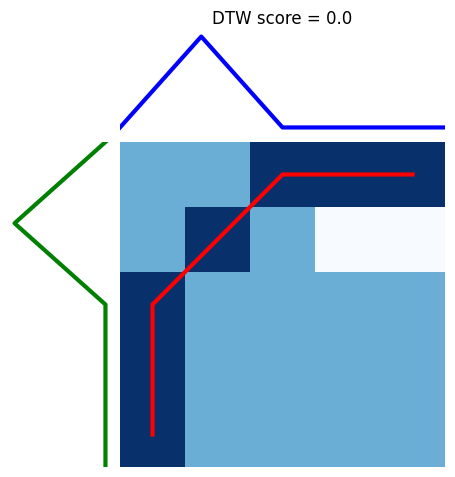

In [724]:
plot_dtw_kws(seq_a, seq_b)

Since every point on this sequence pair can be mapped to a point that has exactly the same value, we get a DTW score of 0, indicating perfect alignment.

Let's do the same with a sine and cosine wave.

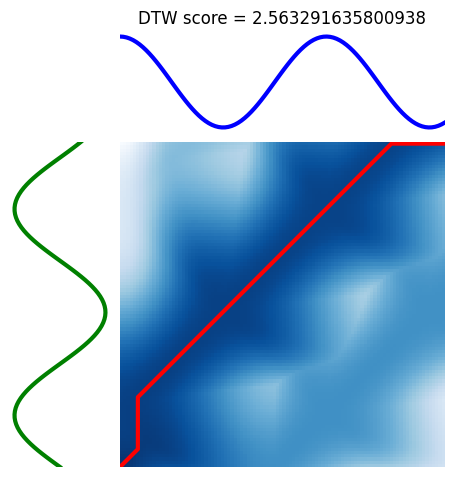

In [725]:
sin_seq = np.sin(np.arange(0, 10, step=0.1))
cos_seq = np.cos(np.arange(0, 10, step=0.1))
plot_dtw_kws(sin_seq, cos_seq)

As we can see, since cosine and sine waves are basically the same function shifted by $\pi/2$, there's a vertical section near the beginning and a horizontal section near the end that accounts for the misalingment, but for the rest of the DTW graph the path line is perfectly diagonal. In this case, we cannot perfectly align each point of one sequence to a point with 0 distance from it in the other sequence, so we get a nonzero DTW score.

**EXERCISE 1:** Modify the code below to produce two pairs of sequences, the first pair where the DTW score is low (the sequences are very similar) and the second where the DTW score is high (the sequences are very different).

For the first pair, try to make the sequences have a similar *shape* but different *alignment*, like `seq_a, seq_b` from above. Feel free to change the length of the arrays, to set values manually, or to use some function (e.g. `np.sin`, `np.tan`, `np.exp`, `np.factorial`, ...)

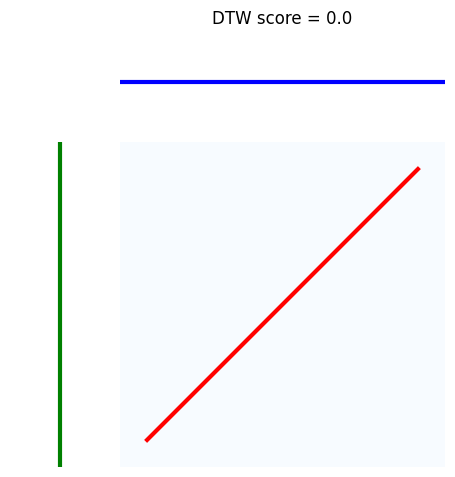

In [726]:
# YOUR CODE HERE:
seq_a_lowscore = np.array([0,0,0,0,0,0])
seq_b_lowscore = np.array([0,0,0,0,0,0])


plot_dtw_kws(seq_a_lowscore, seq_b_lowscore)

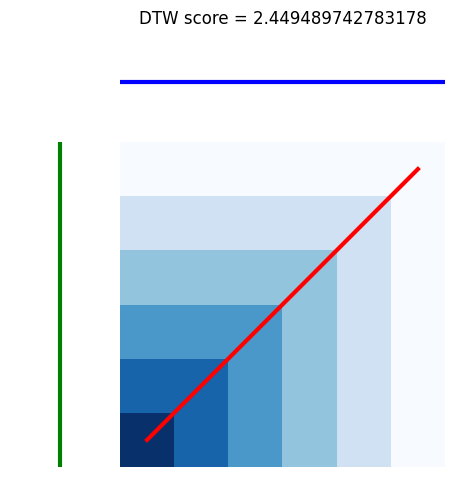

In [727]:
# YOUR CODE HERE:

seq_a_highscore = np.array([0,0,0,0,0,0])
seq_b_highscore = np.array([1,1,1,1,1,1])


plot_dtw_kws(seq_a_highscore, seq_b_highscore)

## Section 2: Encoding audio with MFCCs
MFCCs (Mel Frequency Cepstral Coefficients) are an algorithm for encoding speech into a sequence of vectors that is useful for machine learning. MFCCs rely on a series of signal processing steps to condense the waveform into a representation that is optimized for the kind of information that is useful for understanding speech.

While it would be great to go more into how they work rather than giving this handwavy description I've given here, all we need to know in order to use MFCCs for KWS is that they are a useful way of encoding audio. Here are [some more videos from Herman Kamper](https://www.youtube.com/playlist?list=PLmZlBIcArwhN8nFJ8VL1jLM2Qe7YCcmAb) if you want to learn more about various signal processing methods for working with speech data.

To give a brief demonstration of MFCCs, let's load some toy data I made for a previous class project. The data consists only of the words "lawn, lean, gnaw, knee, kneel" and is stored in the `data/` directory of this github project. I've included some helper functions (stored in `librikws.py`) to load the TextGrid data into a `pandas.DataFrame`.

In [728]:
df = textgrid_to_df('data/ailn.TextGrid')
df.head()

,start,end,value,tier
0,1.936085,2.017377,l,phone
1,2.017377,2.248902,a,phone
2,2.248902,2.408397,n,phone
3,3.012286,3.106954,l,phone
4,3.106954,3.378611,i,phone


In [729]:
df[df['tier']=='word'].head()

,start,end,value,tier
13,1.936085,2.408397,lawn,word
14,3.012286,3.490772,lean,word
15,4.195235,4.716939,kneel,word
16,5.330090,5.692299,knee,word
17,6.445389,6.790104,gnaw,word


Notice that every row in the dataframe corresponds to an interval from the Praat TextGrid, containing start and end timestamps, 'value' (either a phone label or a word label) and tier (phone or word).

Let's now load the wav file.

In [730]:
wav, samplerate = librosa.load('data/ailn.wav')
wav.shape, samplerate

((190560,), 22050)

Now that we've loaded the data, let's calculate MFCCs for the wav file. We can use `librosa.feature.mfcc` to do this.

In [731]:
mfcc_matrix = librosa.feature.mfcc(y=wav, sr=samplerate, n_mfcc=13)
mfcc_matrix.shape

(13, 373)

Our MFCCs come in a `(13, 373)` shaped matrix. That means that our audio is divided into 373 windows, and for each of these windows is represented with a vector of length 13.

Next we want to be able to map the MFCCs to their respective phoneme. Let's do this by adding the columns `start_sample` and `end_sample` that indicate the start and end timestamps in terms of samples of the waveform instead of seconds.

In [732]:
df['start_sample'] = (df['start']*samplerate).astype(int)
df['end_sample'] = (df['end']*samplerate).astype(int)
df.head()

,start,end,value,tier,start_sample,end_sample
0,1.936085,2.017377,l,phone,42690,44483
1,2.017377,2.248902,a,phone,44483,49588
2,2.248902,2.408397,n,phone,49588,53105
3,3.012286,3.106954,l,phone,66420,68508
4,3.106954,3.378611,i,phone,68508,74498


Let's then figure out how many samples are in a single window for the MFCC matrix.

In [733]:
mfcc_window_count = mfcc_matrix.shape[1]
num_samples = wav.shape[0]
samples_per_mfcc_window = num_samples//mfcc_window_count
samples_per_mfcc_window

510

It turns out there are 510 samples in a given MFCC window. We can use this information to map each row to the relevant MFCC vectors.

In [734]:
df['mfcc_index_start']=df['start_sample']//samples_per_mfcc_window
df['mfcc_index_end']=df['end_sample']//samples_per_mfcc_window-1

df.head()

,start,end,value,tier,start_sample,end_sample,mfcc_index_start,mfcc_index_end
0,1.936085,2.017377,l,phone,42690,44483,83,86
1,2.017377,2.248902,a,phone,44483,49588,87,96
2,2.248902,2.408397,n,phone,49588,53105,97,103
3,3.012286,3.106954,l,phone,66420,68508,130,133
4,3.106954,3.378611,i,phone,68508,74498,134,145


Now we want to map MFCCs to a particular phone. First let's make a list with all unique phones in the dataset, and then create a vector mapping each MFCC to its phoneme using the index of the phone given in the `phones` list.

In [735]:
phones = list(df.loc[df['tier']=='phone', 'value'].unique())
phones

['l', 'a', 'n', 'i']

In [736]:
mfcc_phone_ids = np.full(mfcc_window_count, fill_value=-1, dtype=int)

def set_mfcc_phoneme_ids(row):
    mfcc_phone_ids[row['mfcc_index_start']:row['mfcc_index_end']]=phones.index(row['value'])

df[df['tier']=='phone'].apply(set_mfcc_phoneme_ids, axis=1)
mfcc_phone_ids

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,
        0, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  2,  2,  2,  2,  2,
        2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3, -1,  2,  2,  2, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2,  2,  2,  2,  2, -1,
        3,  3,  3,  3,  3,  3, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

The vector `mfcc_phone_ids` gives the index of the phone corresponding to each MFCC window. The large amount of -1's in the vector reflect silent intervals between words. Where a value is greater than -1, e.g. `mfcc_phone_ids[85]=0`, it reflects that the 85th MFCC window corresponds to the phoneme indexed at position 0 on the `phones` list, that is the phone [l].

In [737]:
mfcc_phone_ids[85], phones[mfcc_phone_ids[85]]

(np.int64(0), 'l')

Now we're almost ready to visualize the MFCCS for each phone. There's just one remaining issue: humans can't see in 13 dimensions at once! In order to visualize the 13-coefficient MFCC vectors, thne, we need to perform dimensionality reduction. Since we're just worried about demonstrating and exploring here, t-SNE works perfectly fine.

In [738]:
mfcc_tsne = sklearn.manifold.TSNE().fit_transform(mfcc_matrix.T)
mfcc_tsne.shape

(373, 2)

Let's save the t-SNE embeddings to a dataframe, associate them with their phone labels, and make a mask to ignore all rows corresponding to silence.

In [739]:
tsne_df = pd.DataFrame(mfcc_tsne)
tsne_df['phone']=mfcc_phone_ids
tsne_df['phone']=tsne_df['phone'].apply(lambda i: phones[i] if i>=0 else '')
speech_mask = tsne_df['phone']!=''

tsne_df[speech_mask].head()

,0,1,phone
83,16.901545,-3.419062,l
84,19.998213,-2.720053,l
85,22.535534,-2.505576,l
87,37.605412,0.564326,a
88,38.206837,0.591064,a


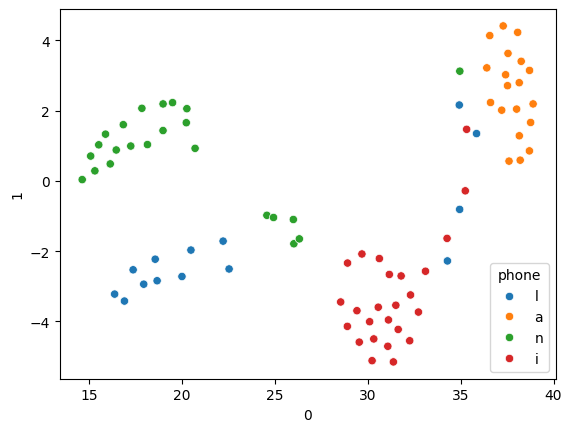

In [740]:
sns.scatterplot(tsne_df[speech_mask], x=0, y=1, hue='phone')
plt.show()

And voi-là! The t-SNE of the MFCCs shows pretty good clustering by phone. The few points that are far from their cluster, e.g. the [l] points that are close to [a] and [i], likely come from the boundaries between phones, where the transition from one phone to the next is a continuous gradient.

**EXERCISE 2:** In the cell below I've written code to create an array that maps MFCC windows to their *word* index, as indicated in the `words` list. Use this array to
1. For each of the five words 'lawn, lean, knee, kneel, gnaw' predict what word will be *closest* and what word will be *furthest* from it.
    - lawn:
    - lean:
    - knee:
    - kneel:
    - gnaw:
2. Write a function to get a matrix of all MFCCs for a given word (`np.argwhere(mfcc_word_ids=word_index)` will be helpful here)
3. Get the DTW score for each word. You can plot it with `plot_dtw` if you wish. To just get the DTW score call `dtw(seq_a, seq_b)`.

In [741]:
words = df.loc[df['tier']=='word', 'value'].unique().tolist()
mfcc_word_ids = np.full(mfcc_window_count, fill_value=-1, dtype=int)

def set_mfcc_word_ids(row):
    mfcc_word_ids[row['mfcc_index_start']:row['mfcc_index_end']]=words.index(row['value'])

df[df['tier']=='word'].apply(set_mfcc_word_ids, axis=1)
mfcc_word_ids

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [742]:
def get_mfccs_for_word(
        word: str,
        mfcc_word_ids: np.ndarray,
        mfcc_matrix: np.ndarray
    ) -> np.ndarray:
    # YOUR CODE HERE
    return mfcc_matrix[:]

get_mfccs_for_word('lawn', mfcc_word_ids, mfcc_matrix)

array([[-4.3166992e+02, -4.5508130e+02, -5.3903082e+02, ...,
        -5.5142865e+02, -5.5355457e+02, -5.5088544e+02],
       [ 1.3146548e+02,  1.2417596e+02,  5.6244881e+01, ...,
         2.9887390e+01,  2.7774982e+01,  3.5907806e+01],
       [ 4.1557442e+01,  5.1149361e+01,  5.3063187e+01, ...,
         2.7493862e+01,  2.5557379e+01,  3.0632099e+01],
       ...,
       [ 6.7447960e-01,  7.3510942e+00,  1.3391247e+01, ...,
         4.8961085e-01,  2.8484871e+00,  4.1989708e+00],
       [-1.5469372e+00,  2.6785069e+00,  1.2074921e+01, ...,
         4.7442532e+00,  7.2864304e+00,  6.2969155e+00],
       [-1.8290899e+00,  1.8607743e+00,  1.1394626e+01, ...,
         5.0757599e+00,  6.4823227e+00,  6.7462683e+00]],
      shape=(13, 373), dtype=float32)

In [743]:
for word_a in words:
    for word_b in words:
        # YOUR CODE HERE: calculate the DTW score for word_a and word_b!
        ...

Now that we've got some practice with MFCCs and in using them in DTW, we're going to start looking at some real KWS data. We'll be working with the [LibriSpeech](https://ieeexplore.ieee.org/document/7178964) and [LibriPhrase](https://arxiv.org/abs/2206.15400) datasets. LibriSpeech is an ASR dataset made from public domain audiobooks, and LibriPhrase is a KWS dataset where keywords were sampled from sentences in LibriSpeech. I've saved these datasets onto Witchking and provided some helper functions defined in `librikws.py` to load data from them.

In [744]:
keywords = get_unique_keywords()
print(f"{len(keywords)} keywords in dataset")
keywords[:10]

9872 keywords in dataset


['sixteen fifty',
 'the house',
 'my son',
 'my wife',
 'thousand francs',
 'his daughter',
 'the king',
 'the restoration',
 'the community',
 'the patient']

In [745]:
keyword, sentence = get_random_keyword_sentence_pair(keywords[42])
keyword

word_index                                                    1191
index                                                         1191
file             train-clean-100/1970/26100/1970-26100-0028_2wo...
speaker                                                       1970
keyword                                                    i asked
dur                                                           0.76
class                                                            2
sentence_file      train-clean-100/1970/26100/1970-26100-0028.flac
Name: 1191, dtype: object

In [746]:
sentence

sentence_index                                                12578
speaker                                                        6454
chapter                                                       93938
file                train-clean-100/6454/93938/6454-93938-0004.flac
sentence          and answered that i asked an adjournment of th...
Name: 12578, dtype: object

Let's write a function to get MFCCs + the first and second derivatives for a given audio. We'll use this as feature extraction for doing KWS.

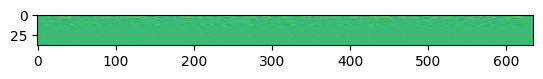

In [747]:
def mfcc_w_deltas(audio: Union[str, np.ndarray], samplerate: Optional[int]=None) -> np.ndarray:
    if type(audio) is str:
        audio, samplerate = librosa.load(audio)
    mfcc = librosa.feature.mfcc(y=audio, sr=samplerate, n_mfcc=13)
    d1 = librosa.feature.delta(mfcc, order=1)
    d2 = librosa.feature.delta(mfcc, order=2)

    feature = np.concat([mfcc, d1, d2], axis=0)
    return feature

_, ax = plt.subplots()
ax.imshow(mfcc_w_deltas(get_librispeech_path(sentence['file'])))
plt.show()

In order to visualize DTW between a keyword and a sentence, let's write another function to plot a sentence and keyword similar to the style used in `plot_dtw` above.

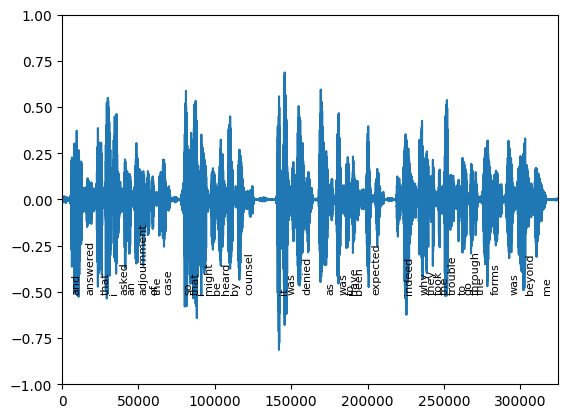

In [748]:
def plot_sentence(
        row: pd.Series,
        tier: str='words',
        stop_tokens: List[str] = ['sp', 'sil'],
        ax: Optional[plt.Axes] = None,
        audio_type: Literal['wav', 'mfcc']='wav'
    ):
    if ax is None:
        _, ax = plt.subplots()
    audio_path = get_librispeech_path(row['file'])
    wav, samplerate = librosa.load(audio_path)
    textgrid_df = get_librispeech_textgrid(row['file'])

    mfcc = mfcc_w_deltas(wav, samplerate)
    if audio_type == 'mfcc':
        text_y=30
        ax.imshow(mfcc)
        audio = mfcc
    else:
        audio = wav
        ax.plot(audio)
        text_y=-0.5
        ax.set_ylim((-1,1))
        
    max_time = textgrid_df['end'].max()
    max_X = audio.shape[-1]
    ax.set_xlim(0, max_X)


    midpoint=(textgrid_df['start']+textgrid_df['end'])/2
    midpoint_relative = midpoint/max_time
    midpoint_X = midpoint_relative*max_X
    textgrid_df['midpoint_X']=midpoint_X

    plot_word = lambda row: ax.text(
        x = row['midpoint_X'],
        y=text_y,
        s = row['value'],
        rotation=90,
        fontsize=8,
    )
    tier_mask = textgrid_df['tier']==tier
    stoptoken_mask = textgrid_df['value'].isin(stop_tokens)
    textgrid_df[tier_mask&~stoptoken_mask].apply(plot_word, axis=1)


    return mfcc.T

plot_sentence(sentence)
plt.show()

The `audio_type` arg let's us choose between visualizing the waveform or MFCCs.

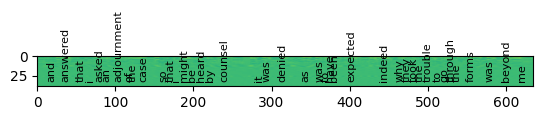

In [749]:
plot_sentence(sentence, audio_type='mfcc')
plt.show()

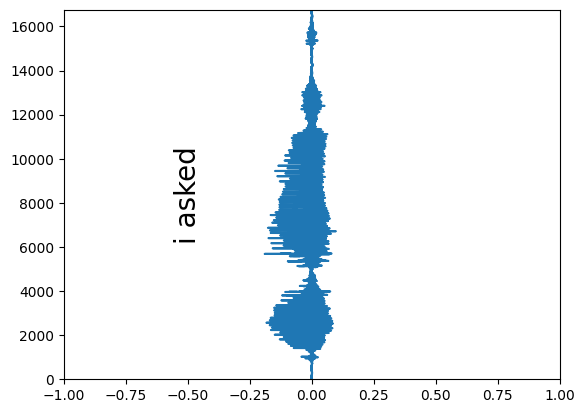

In [750]:
def plot_keyword(
        row: pd.Series,
        ax: Optional[plt.Axes] = None,
        audio_type: Literal['wav', 'mfcc']='wav',
):
    audio_path = get_libriphrase_audio_path(row['file'])

    if ax is None:
        _, ax = plt.subplots()
    mfcc = mfcc_w_deltas(audio_path)
    if audio_type == 'mfcc':
        ax.imshow(mfcc.T)
        text_x=30
        max_y=mfcc.shape[-1]

    else:
        wav, _ = librosa.load(audio_path)
        time = np.arange(wav.shape[-1])
        ax.plot(wav, time)
        ax.set_xlim((-1,1))
        text_x=-0.5
        max_y=wav.shape[-1]

    text_y = max_y/2

    ax.text(
        y=text_y,
        x=text_x,
        s = row['keyword'],
        rotation=90,
        fontsize=20,
        va='center',
        ha='center'
    )


    ax.set_ylim(0, max_y)

    return mfcc.T
plot_keyword(keyword)
plt.show()

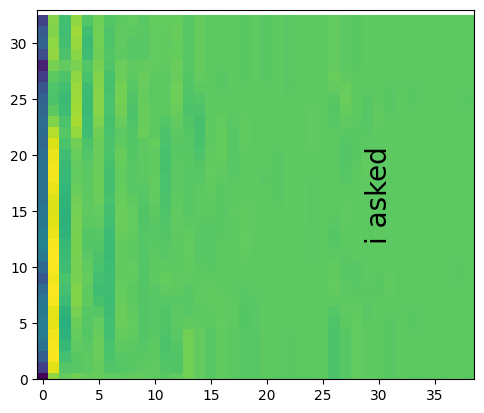

In [751]:
plot_keyword(keyword, audio_type='mfcc')
plt.show()

Let's use these methods to visualize DTW between the MFCCs of the keyword and keyphrase.

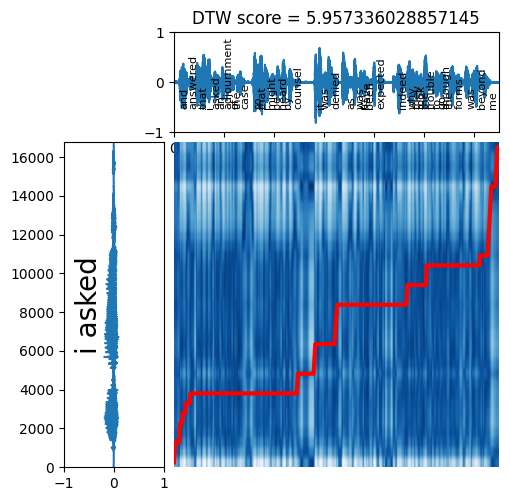

In [752]:
def plot_dtw_mfccs(keyword, sentence):
    """
    Arguments:
        keyword:            pandas.Series containing data for keyword
        sentence:           pandas.Series containing data for sentence
        distance_matrix:    Optional: pre-computed distance matrix (default
                            behavior is to call `get_dtw_matrix(seq_a, seq_b)`)
        path:               Optional: pre-computed path (default behavior is to
                            call `tslearn.dtw_path(seq_a, seq_b)`)
    
    Plots two sequences along with similarity matrix and path.
    """
    left, center, top = get_dtw_axes()

    keyword_mfcc=plot_keyword(keyword, ax=left)
    sentence_mfcc=plot_sentence(sentence, ax=top)
    # dtw_matrix=dtw_matrix = get_dtw_matrix(
    #     keyword_mfcc,
    #     sentence_mfcc,
    #     distance_funct=cosine,
    # )
    distance_matrix = cdist(keyword_mfcc, sentence_mfcc)
    path, _ = dtw_path(keyword_mfcc, sentence_mfcc)
    plot_distance_matrix(distance_matrix, center)
    plot_path(path, center)

    dtw_distance = dtw(keyword_mfcc, sentence_mfcc) / sentence_mfcc.shape[0]
    top.set_title(f"DTW score = {dtw_distance}")

    plt.show()

plot_dtw_mfccs(keyword, sentence)

**EXERCISE 3:** Where the DTW path is more vertical, we are "traversing" along the keyword, as opposed to horizontal lines where we are traversing along the sentence but not along the keyword. Since the keyword is contained within the sentence, we should expect most of the vertical movement to occur at the keyword's location in the audio. Is this actually the case? In the markdown cell below, note the words in the sentence where you see vertical movement along the DTW path, and whether this is in line with what you expected.

Note: The keyword here is set to 'I asked', but the sentence was randomly generated. If the sentence is too long and the words on top are too crowded, try running the cells above again until a shorter sentence is chosen.

YOUR ANWER HERE:

Now, it's not really ideal to compare an *entire* sentence of MFCCs to the keyphrase using DTW. A better strategy is to divide the sentence into a series of windows then compare each window to the keyword. Hopefully, the window with the minimum score will match the keyword (I've indicated the minium DTW score with a vertical red line).

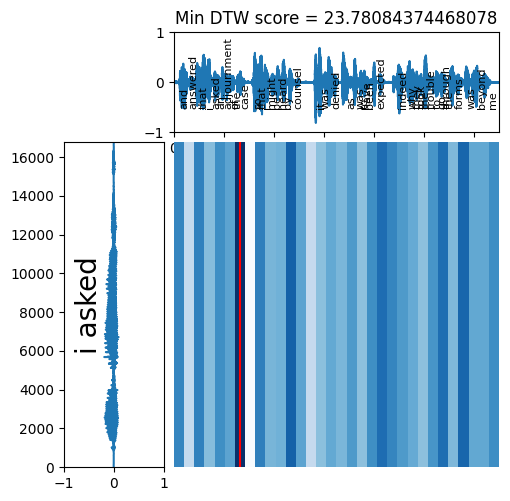

In [753]:
def plot_sliding_dtw(keyword, sentence):
    """
    Arguments:
        keyword:            pandas.Series containing data for keyword
        sentence:           pandas.Series containing data for sentence
        distance_matrix:    Optional: pre-computed distance matrix (default
                            behavior is to call `get_dtw_matrix(seq_a, seq_b)`)
        path:               Optional: pre-computed path (default behavior is to
                            call `tslearn.dtw_path(seq_a, seq_b)`)
    
    Plots two sequences along with similarity matrix and path.
    """
    left, center, top = get_dtw_axes()

    keyword_mfcc=plot_keyword(keyword, ax=left)
    sentence_mfcc=plot_sentence(sentence, ax=top)

    dtw_scores = get_windowed_dtw(keyword_mfcc, sentence_mfcc)
    min_idx = np.argmin(dtw_scores)
    plot_distance_matrix(dtw_scores, center)
    center.vlines(min_idx, -0.5, 0.5, 'red')

    top.set_title(f"Min DTW score = {dtw_scores.min()}")

    plt.show()

def get_windowed_dtw(keyword_mfcc, sentence_mfcc):
    window_len = min(int(keyword_mfcc.shape[0]*1.2), sentence_mfcc.shape[0])
    frameshift = window_len//2
    window_shape = (window_len, keyword_mfcc.shape[1])
    sentence_windows = np.lib.stride_tricks.sliding_window_view(
        sentence_mfcc,
        window_shape,
        # axis=1,
    ).squeeze()
    sentence_windows = np.array([window for i, window in enumerate(sentence_windows) if i%frameshift==0])
    dtw_scores = np.array([dtw(keyword_mfcc, window) for window in sentence_windows])
    dtw_scores = dtw_scores[np.newaxis,:]
    dtw_scores/=keyword_mfcc.shape[0]
    return dtw_scores

plot_sliding_dtw(keyword, sentence)

Let's put this to the test with a small dataset. I've saved a csv file with a list of 10 keywords where each keywords is paired with 10 positive sentences (that contain the keyword) and 20 negative (that don't contain the keyword). The imbalance here is intentional: overall, we should expect to come across more instances of negative sentences than positive for any given keyword when applying KWS to novel data.

In [754]:
kws_df = get_samespeaker_kws_df()
kws_df.head()

,sentence_index,speaker,chapter,sentence_file,sentence,label,keyword,keyword_file
0,18901,8630,305213,train-clean-100/8630/305213/8630-305213-0032.flac,even with the help of the most learned profess...,1,augustine,/mnt/LocalStorage/mjsimmons/datasets/LibriPhra...
1,18870,8630,305213,train-clean-100/8630/305213/8630-305213-0001.flac,she needed little it is true for herself but t...,1,augustine,/mnt/LocalStorage/mjsimmons/datasets/LibriPhra...
2,18922,8630,305213,train-clean-100/8630/305213/8630-305213-0053.flac,he found them carnal and loquacious full of in...,1,augustine,/mnt/LocalStorage/mjsimmons/datasets/LibriPhra...
3,18915,8630,305213,train-clean-100/8630/305213/8630-305213-0046.flac,to impose on christians they used christian wo...,1,augustine,/mnt/LocalStorage/mjsimmons/datasets/LibriPhra...
4,18892,8630,305213,train-clean-100/8630/305213/8630-305213-0023.flac,the time passed by unheeded patricius her husb...,1,augustine,/mnt/LocalStorage/mjsimmons/datasets/LibriPhra...


Let's add a column containing the DTW score for each row, and then z-score it.

In [755]:
def get_dtw_prob(row):
    keyword_mfcc = mfcc_w_deltas(get_libriphrase_audio_path(row['keyword_file']))
    sentence_mfcc = mfcc_w_deltas(get_librispeech_path(row['sentence_file']))

    return get_windowed_dtw(keyword_mfcc, sentence_mfcc).min()

kws_df['dtw_score']=kws_df.progress_apply(get_dtw_prob, axis=1)
kws_df.head()

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:04<00:00, 63.86it/s]


,sentence_index,speaker,chapter,sentence_file,sentence,label,keyword,keyword_file,dtw_score
0,18901,8630,305213,train-clean-100/8630/305213/8630-305213-0032.flac,even with the help of the most learned profess...,1,augustine,/mnt/LocalStorage/mjsimmons/datasets/LibriPhra...,15.927806
1,18870,8630,305213,train-clean-100/8630/305213/8630-305213-0001.flac,she needed little it is true for herself but t...,1,augustine,/mnt/LocalStorage/mjsimmons/datasets/LibriPhra...,16.907603
2,18922,8630,305213,train-clean-100/8630/305213/8630-305213-0053.flac,he found them carnal and loquacious full of in...,1,augustine,/mnt/LocalStorage/mjsimmons/datasets/LibriPhra...,15.549410
3,18915,8630,305213,train-clean-100/8630/305213/8630-305213-0046.flac,to impose on christians they used christian wo...,1,augustine,/mnt/LocalStorage/mjsimmons/datasets/LibriPhra...,13.916002
4,18892,8630,305213,train-clean-100/8630/305213/8630-305213-0023.flac,the time passed by unheeded patricius her husb...,1,augustine,/mnt/LocalStorage/mjsimmons/datasets/LibriPhra...,15.258094


<Axes: >

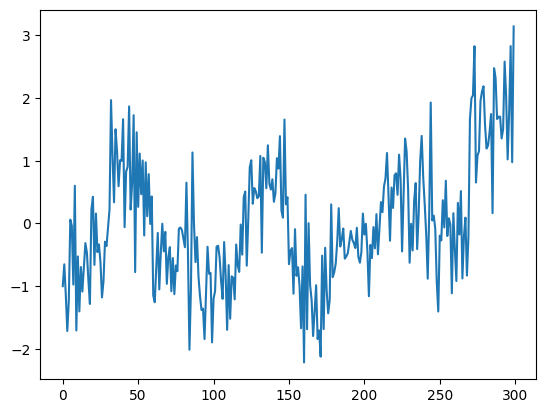

In [759]:
kws_df['dtw_score_norm'] = (kws_df['dtw_score']-kws_df['dtw_score'].mean())\
    / kws_df['dtw_score'].std()
kws_df['dtw_score_norm'].plot()

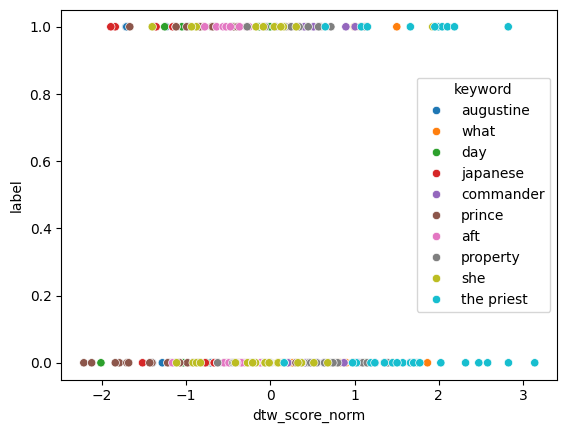

In [760]:
mask = kws_df['keyword'].isin(["commander", "japanese"])
sns.scatterplot(kws_df[:], y='label', x='dtw_score_norm', hue='keyword')
plt.show()

Here's an [article](https://www.geeksforgeeks.org/machine-learning/auc-roc-curve/) and a [video with cringy intro song](https://www.youtube.com/watch?v=4jRBRDbJemM) on ROC/AUC.

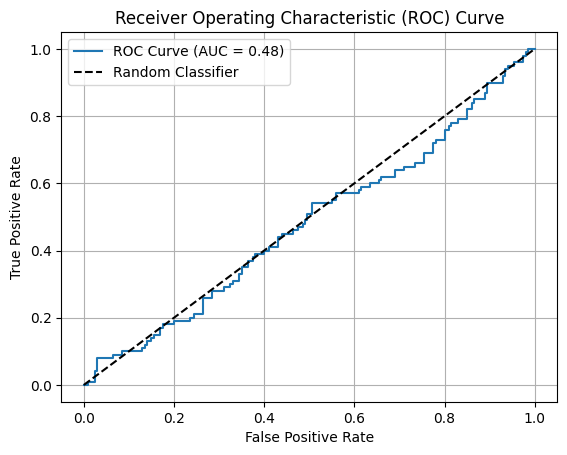

In [761]:
# mask = kws_df['keyword']=='augustine'

Y = kws_df['label']
Y_hat = kws_df['dtw_score_norm']

fpr, tpr, thresholds = roc_curve(Y, Y_hat)
auc = roc_auc_score(Y, Y_hat)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()